## Installing Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [0]:
#!pip install git+https://github.com/coreylynch/pyFM
import numpy as np
import pandas as pd
from datetime import datetime
import json
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
import itertools
import scipy as sp
from sklearn.feature_extraction import DictVectorizer
from pyfm import pylibfm
from sklearn.preprocessing import normalize
from scipy import sparse
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

## Data Loading and Preparation

In [3]:
user = pd.read_csv("/content/drive/My Drive/yelp_dataset/user1.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
user = user.iloc[:,1:]
list_rmse = []

In [0]:
data2= pd.read_csv("/content/drive/My Drive/dataP.csv")
data1 = data2.copy()

mask_restaurants = data1['categories'].str.contains('Restaurants')
mask_food = data1['categories'].str.contains('Food')
restaurants_and_food = data1[mask_restaurants & mask_food]
restaurants_and_food_business_ids = restaurants_and_food.business_id.to_list()
data1['isRestaurant'] = data1.business_id.isin(restaurants_and_food_business_ids).astype(int)
data1 = data1[data1.loc[:,'isRestaurant'] == 1]
data1 = data1.iloc[:,:36]

## Defining a function for Factorization machine with no embeddings

In [0]:
def FM_NE(data1):  
  #Clean data
  merged = data1
  merged = merged.drop(columns=['address',
                                'state', 
                                'postal_code', 
                                'hours'])

  data3 = merged

  data3 = data3.drop(columns=['name',
  'city',
  'yelping_since'])
  data3.rename(columns = {'rating_x':'rating'}, inplace = True) 
  
  #Splitting test and train. Test set comprises of the users and the restaurants that the user rated last.
  data_test = data3[data3.groupby('user_id')['date'].transform('max') == data3['date']]
  data_train = pd.concat([data3, data_test]).drop_duplicates(keep=False)

  
  #Preparing data for the FM model
  y_train = np.squeeze(data_train[['rating']].to_numpy())
  y_test =  np.squeeze(data_test[['rating']].to_numpy())


  x_train = data_train
  x_train = x_train.drop(columns=['date','attributes','categories','yrs_elite','rating'])
  x_train_final = x_train.to_dict('records')


  x_test = data_test
  x_test = x_test.drop(columns=['date','attributes','categories','yrs_elite','rating'])
  x_test_final = x_test.to_dict('records')

  v = DictVectorizer()
  X_train = v.fit_transform(x_train_final)
  X_test = v.transform(x_test_final)

  #Fitting the model and predicting
  fm = pylibfm.FM(num_iter=10, task="regression", learning_rate_schedule="optimal")
  fm.fit(normalize(sparse.csr_matrix(X_train)), y_train)

  #Calculating the RMSE value
  prediction = fm.predict(normalize(sparse.csr_matrix(X_test)))
  list_rmse.append(mean_squared_error(y_test,preds))
  print("FM MSE: %.4f" % mean_squared_error(y_test,prediction))

## Defining a function for Factorization machine with categories as embeddings

In [0]:
def FM_E(data2):
  
  #Category Embedding
  temp = data2.copy()
  temp['categories'] = temp['categories'].apply(lambda x : x.split(","))
  cat_list = list(temp['categories'])
  mlb = MultiLabelBinarizer()
  temp1 = mlb.fit_transform(cat_list)
  names = mlb.classes_
  cat_df = pd.DataFrame(temp1,columns=names)
  merged_2 = pd.concat([data2.reset_index(),cat_df],axis=1)

  merged_2 = merged_2.drop(columns=['address',
                                'state', 
                                'postal_code', 
                                'hours'])
  data3 = merged_2.copy()
  data3 = data3.drop(columns=['Unnamed: 0',
                              'index',
  'name',
  'city',
  'yelping_since'])
  data3.rename(columns = {'rating_x':'rating'}, inplace = True) 

  #Splitting test and train. Test set comprises of the users and the restaurants that the user rated last.
  data_test = data3[data3.groupby('user_id')['date'].transform('max') == data3['date']]
  data_train = pd.concat([data3, data_test]).drop_duplicates(keep=False)

  list3 = data_train['user_id'].unique().tolist()
  data_test['isActive'] = data_test.user_id.isin(list3).astype(int)
  data_test = data_test[data_test.loc[:,'isActive'] == 1]
  data_test = data_test.iloc[:,:434]

  list3 = data_train['user_id'].unique().tolist()
  data_test['isActive'] = data_test.user_id.isin(list3).astype(int)
  data_test = data_test[data_test.loc[:,'isActive'] == 1]
  data_test = data_test.iloc[:,:434]

  #Preparing data for the FM model
  y_train = np.squeeze(data_train[['rating']].to_numpy())
  y_test =  np.squeeze(data_test[['rating']].to_numpy())

  x_train = data_train.iloc[:,:28]
  x_train = x_train.drop(columns=['date','attributes','categories','yrs_elite','rating'])
  x_train_final = x_train.to_dict('records')


  x_train_rem  = data_train.iloc[:,28:]
  x_train_rem_final = x_train_rem.to_numpy()
  x_train_rem_final = sp.sparse.csr_matrix(x_train_rem_final)


  x_test = data_test.iloc[:,:28]
  x_test = x_test.drop(columns=['date','attributes','categories','yrs_elite','rating'])
  x_test_final = x_test.to_dict('records')


  x_test_rem  = data_test.iloc[:,28:]
  x_test_rem_final = x_test_rem.to_numpy()
  x_test_rem_final = sp.sparse.csr_matrix(x_test_rem)

  v = DictVectorizer()
  X_train = v.fit_transform(x_train_final)
  X_test = v.transform(x_test_final)

  X_train_final = sp.sparse.hstack([X_train, x_train_rem_final])
  X_test_final = sp.sparse.hstack([X_test, x_test_rem_final])

  #Fitting the model and predicting
  fm = pylibfm.FM(num_iter=10, task="regression", learning_rate_schedule="optimal")
  fm.fit(normalize(sparse.csr_matrix(X_train_final)), y_train)

  #Calculating the RMSE value
  prediction = fm.predict(normalize(sparse.csr_matrix(X_test_final)))
  list_rmse.append(mean_squared_error(y_test,preds))
  print("FM MSE: %.4f" % mean_squared_error(y_test,prediction))

## With Category as Embeddings 

In [8]:
FM_E(data1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.69285
-- Epoch 2
Training MSE: 0.69959
-- Epoch 3
Training MSE: 0.69858
-- Epoch 4
Training MSE: 0.70019
-- Epoch 5
Training MSE: 0.69929
-- Epoch 6
Training MSE: 0.69940
-- Epoch 7
Training MSE: 0.69976
-- Epoch 8
Training MSE: 0.69998
-- Epoch 9
Training MSE: 0.69976
-- Epoch 10
Training MSE: 0.69960
FM MSE: 1.6975


## Without Category as embeddings 

In [9]:
FM_NE(data2)

Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.77708
-- Epoch 2
Training MSE: 0.77444
-- Epoch 3
Training MSE: 0.77236
-- Epoch 4
Training MSE: 0.77156
-- Epoch 5
Training MSE: 0.77153
-- Epoch 6
Training MSE: 0.77081
-- Epoch 7
Training MSE: 0.77101
-- Epoch 8
Training MSE: 0.77090
-- Epoch 9
Training MSE: 0.77082
-- Epoch 10
Training MSE: 0.77079
FM MSE: 1.9171


## Plot for Model Type vs RMSE

In [0]:
names = ["Category Embeddings", "No embeddings", "Baseline-ALS", "Baseline-Surprise"]
for i in range(len(list_rmse)):
  list_rmse[i] = math.sqrt(list_rmse[i])
type_1 = ["Sample2","Sample2", "Sample2", "Sample2"]
list_rmse.append(1.440)
list_rmse.append(1.382)

In [0]:
df = pd.DataFrame(list(zip(names, list_rmse, type_1)), 
               columns =['Model type', 'RMSE', 'Sample Type'])

Text(0.5, 1.0, 'Model Type vs RMSE')

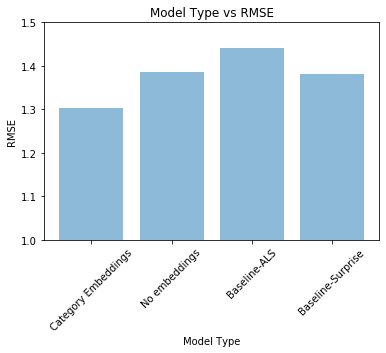

In [17]:
plt.bar(df['Model type'], df['RMSE'], align='center', alpha=0.5)
plt.xlabel('Model Type')
plt.ylabel('RMSE')
plt.ylim((1.0,1.5))
plt.xticks(rotation=45)
plt.title('Model Type vs RMSE')